# 1. Simple CNN Model

In [1]:
import os

base_dir = os.getcwd()

# dataset paths
dataset_path = os.path.join(base_dir, 'datasets')
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

# 저장할 model path
save_dir = os.path.join(base_dir, 'saved_models')

classes = ['0_front', '1_back', '1_front', '2_back', '2_front', '5_front', 'ILU']

# train, validation의 각 class별 directory path
train_cls_dirs = [os.path.join(train_dir, c) for c in classes]
val_cls_dirs = [os.path.join(val_dir, c) for c in classes]

In [2]:
import cv2
import numpy as np

# Load dataset
def get_X_y_datas(class_dirs):
    X = []
    y = []
    for i, dir_path in enumerate(class_dirs):
        files = sorted(os.listdir(class_dirs[i]))
        files_paths = [os.path.join(dir_path, f) for f in files]
        
        for file_path in files_paths:
            img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            input_img = img_rgb.astype(np.float32)/255.
            
            X.append(input_img)
            y.append(int(i))
            
    return np.array(X), np.array(y).astype(np.uint8)

In [3]:
from tensorflow.keras.utils import to_categorical

num_classes = 7

# Load train, validation datas
X_train, y_train = get_X_y_datas(train_cls_dirs)
X_val, y_val = get_X_y_datas(val_cls_dirs)

# Shuffle
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]

# one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18654, 250, 200, 3) (18654, 7)
(9222, 250, 200, 3) (9222, 7)


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# 학습에 사용할 callback
callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
    ),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, 'hand_sign_simple_cnn.h5'),
        monitor='val_loss',
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

In [5]:
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

h = 250 # height
w = 200 # width
c = 3  # channels

# Multi GPU
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = models.Sequential()

    model.add(layers.Conv2D(16, 3, input_shape=(h, w, c,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [6]:
batch_size = 64
n_epochs = 100

history = model.fit(X_train, y_train,
                    epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list)

Train on 18654 samples, validate on 9222 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
18654/18654 [==============================] - 29s 2ms/sample - loss: 1.4428 - acc: 0.4497 - val_loss: 2.3275 - val_acc: 0.2555
Epoch 2/100
18654/18654 [==============================] - 8s 453us/sample - loss: 0.5923 - acc: 0.8010 - val_loss: 0.8609 - val_acc: 0.7096
Epoch 3/100
18654/18654 [==============================] - 8s 440us/sample - loss: 0.3021 - acc: 0.9023 - val_loss: 1.4292 - val_acc: 0.6242
Epoch 4/100
18654/18654 [==============================] - 8s 444us/sample - loss: 0.1890 - acc: 0.9396 - val_loss: 0.3189 - val_acc: 0.8957
Epoch 5/100
18654/18654 [==============================] - 8s 439us/sample - loss: 0

Epoch 50/100
18654/18654 [==============================] - 8s 446us/sample - loss: 7.5158e-06 - acc: 1.0000 - val_loss: 0.0740 - val_acc: 0.9853
Epoch 51/100
18654/18654 [==============================] - 8s 450us/sample - loss: 5.8828e-06 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9851
Epoch 52/100
18654/18654 [==============================] - 9s 458us/sample - loss: 1.5705e-05 - acc: 1.0000 - val_loss: 0.0729 - val_acc: 0.9850
Epoch 53/100
18624/18654 [============================>.] - ETA: 0s - loss: 1.0183e-05 - acc: 1.0000
Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
18654/18654 [==============================] - 8s 445us/sample - loss: 1.0175e-05 - acc: 1.0000 - val_loss: 0.0741 - val_acc: 0.9857


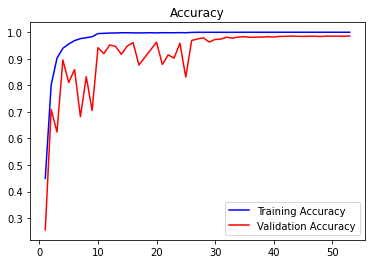

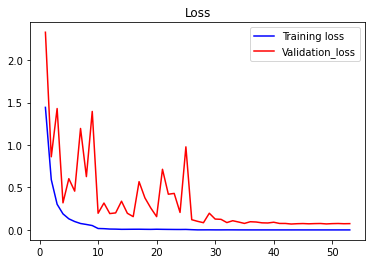

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy curve
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

# Plot loss curve
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation_loss')
plt.title('Loss')
plt.legend()

plt.show()

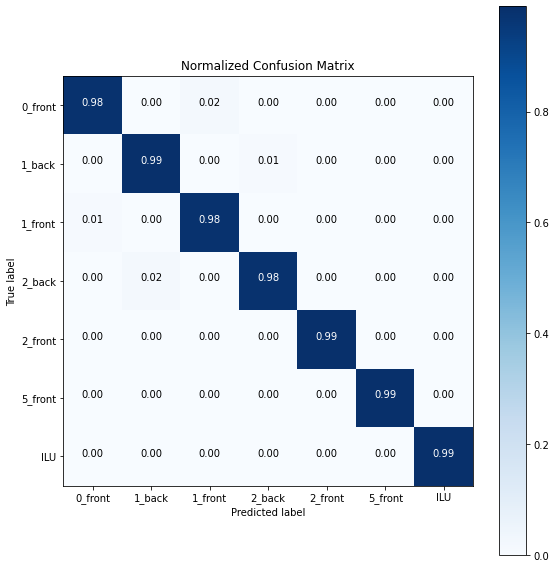

In [8]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

y_preds = model.predict(X_val)
y_preds = np.argmax(y_preds, axis=1)
conf_mx = confusion_matrix(np.argmax(y_val, axis=1), y_preds)

confusion_matrix_plot(conf_mx, classes=classes)